In [147]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers

pd.set_option('display.max_rows', None)

What is the lower bound for the number of training examples, N?
- N >= n
- lower bound is amount of rbf kernels n

What happens with the error if N = n? Why?
- if we have as many rbf kernels n as samples N then we are overfitting, each rbf kernel can select one sample as its prototype vector and the error is 0

Under what conditions, if any, does (4) have a solution in this case?
- ??

During training we use an error measure defined over the training examples. Is it good to use this measure when evaluating the performance of the network? Explain!
- No, because we don't get information about the generalization error.
- We do not notice if we overfit or not, if we do not use validation / test sets.


# 3.1 Supervised learning of RBF NN

In [347]:
def sin_function(x):
    return np.sin(2 * x).reshape(-1, 1)


def square_function(x):
    return (np.sin(2 * x) >= 0).astype(float).reshape(-1, 1)


def generate_X(start=0, stop=2 * np.pi, step_size=0.1):
    return np.arange(start, stop, step_size).reshape(-1, 1)


def get_train_data():
    X_train = generate_X()
    y_train_sin = sin_function(X_train)
    y_train_square = square_function(X_train)

    return X_train, y_train_sin, y_train_square


def get_test_data():
    X_test = generate_X(start=0.05)
    y_test_sin = sin_function(X_test)
    y_test_square = square_function(X_test)

    return X_test, y_test_sin, y_test_square


def get_rbf_kernels(num, std=0.2):
    number_of_kernel = num

    rbf_center_sin = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_sin = sin_function(rbf_center_sin)

    rbf_center_square = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_square = square_function(rbf_center_square)

    kernel_stds = std * np.ones((len(rbf_center_square),)).reshape(-1, 1)

    return kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square


X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(10)

residual_error_thresholds = [0.1, 0.01, 0.001]


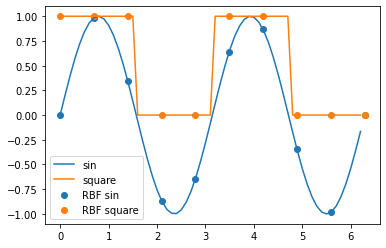

In [265]:
plt.plot(X_train, y_train_sin, label="sin")
plt.plot(X_train, y_train_square, label="square")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF sin")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF square")
plt.legend()
plt.show()


In [298]:
class RBFNet:
    def __init__(self, kernel_centers, kernel_stds, lr=0.01, epochs=1):
        self.lr = lr
        self.epochs = epochs
        self.kernel_centers = kernel_centers
        self.kernel_stds = kernel_stds
        self.k = len(kernel_centers)
        self.w = np.random.randn(self.k, 1)

    def rbf_function(self, x, center, std):
        return np.exp(-((x - center) ** 2) / (2 * std ** 2))

    def calc_expanded_X(self, X):
        rows = []
        for i in range(X.shape[0]):
            row = [self.rbf_function(X[i], c, s) for c, s, in zip(self.kernel_centers, self.kernel_stds)]
            rows.append(row)
        phi = np.hstack(rows).T  # vstack does not work :((((((((
        assert phi.shape == (X.shape[0], self.k)
        return phi

    def forward_pass(self, X):
        phi = self.calc_expanded_X(X)
        return phi @ self.w

    def sum_of_squared_diff(self, y_pred, y_true):
        return np.sum((y_pred - y_true) ** 2)

    def mean_absolute_error(self, y_pred, y_true):
        return 1 / len(y_pred) * np.sum((y_pred - y_true) ** 2)

    def backward_pass(self, X, y):
        phi = self.calc_expanded_X(X)
        inv_cov = np.linalg.inv(phi.T @ phi)
        self.w = inv_cov @ phi.T @ y

    def fit(self, X, y):
        for epoch in range(self.epochs):
            self.backward_pass(X, y)

            y_pred = self.forward_pass(X)
            loss = self.sum_of_squared_diff(y_pred, y)
            print(f"Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_pass(X)

    def fit_and_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

    def evaluate_residual_error(self, X, y):
        y_pred = self.predict(X)
        loss = self.mean_absolute_error(y_pred, y)
        print(f"Residual Error (MAE): {loss:.4f}")
        return loss


Kernels 1
Loss: 24.4868
Residual Error (MAE): 0.3956
Kernels 2
Loss: 24.4868
Residual Error (MAE): 0.3956
Kernels 3
Loss: 21.0600
Residual Error (MAE): 0.3301
Kernels 4
Loss: 12.4883
Residual Error (MAE): 0.2120
Kernels 5
Loss: 14.2565
Residual Error (MAE): 0.2245
Kernels 6
Loss: 4.8916
Residual Error (MAE): 0.0727
Kernels 7
Loss: 2.9885
Residual Error (MAE): 0.0480
Kernels 8
Loss: 2.2412
Residual Error (MAE): 0.0414
Kernels 9
Loss: 2.9226
Residual Error (MAE): 0.0472
Kernels 10
Loss: 2.2495
Residual Error (MAE): 0.0346
Kernels 11
Loss: 2.0223
Residual Error (MAE): 0.0323
Kernels 12
Loss: 1.5075
Residual Error (MAE): 0.0288
Kernels 13
Loss: 1.9071
Residual Error (MAE): 0.0343
Kernels 14
Loss: 1.2004
Residual Error (MAE): 0.0207
Kernels 15
Loss: 1.1537
Residual Error (MAE): 0.0214
Kernels 16
Loss: 1.1571
Residual Error (MAE): 0.0215
Kernels 17
Loss: 1.1720
Residual Error (MAE): 0.0212
Kernels 18
Loss: 1.1442
Residual Error (MAE): 0.0203
Kernels 19
Loss: 1.1021
Residual Error (MAE): 0.01

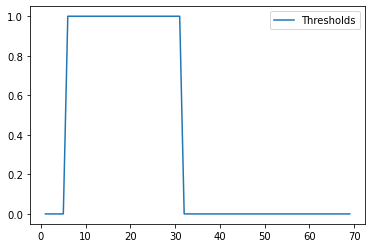

In [359]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()



num_of_kernels = np.arange(1,70,1)
levels = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k, std=0.4)


    rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
    y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square)

    square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square)

    level = 0
    for t in residual_error_thresholds:
        if square_test_loss < t:
            level += 1
    levels.append(level)

plt.plot(num_of_kernels, levels, label="Thresholds")
plt.legend()
plt.show()


Loss: 0.5128
Residual Error (MAE): 0.0147


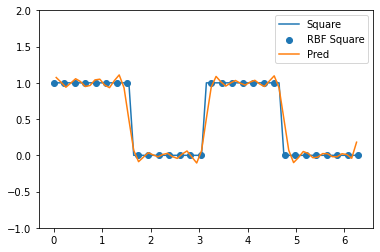

In [366]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=30, std=0.4)

rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square)

square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square)

y_pred_test = rbf_square.predict(X_test)

plt.plot(X_test, y_test_square, label="Square")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF Square")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.ylim(-1,2)
plt.show()


Kernels 1
Loss: 31.3932
Residual Error (MAE): 0.4980
Kernels 2
Loss: 31.3228
Residual Error (MAE): 0.4979
Kernels 3
Loss: 31.3228
Residual Error (MAE): 0.4979
Kernels 4
Loss: 26.2144
Residual Error (MAE): 0.4168
Kernels 5
Loss: 31.3228
Residual Error (MAE): 0.4979
Kernels 6
Loss: 22.8080
Residual Error (MAE): 0.3628
Kernels 7
Loss: 21.1051
Residual Error (MAE): 0.3357
Kernels 8
Loss: 19.4031
Residual Error (MAE): 0.3087
Kernels 9
Loss: 17.6994
Residual Error (MAE): 0.2817
Kernels 10
Loss: 15.9976
Residual Error (MAE): 0.2546
Kernels 11
Loss: 14.2937
Residual Error (MAE): 0.2276
Kernels 12
Loss: 12.5956
Residual Error (MAE): 0.2007
Kernels 13
Loss: 10.9109
Residual Error (MAE): 0.1739
Kernels 14
Loss: 9.2632
Residual Error (MAE): 0.1477
Kernels 15
Loss: 7.6850
Residual Error (MAE): 0.1226
Kernels 16
Loss: 6.2173
Residual Error (MAE): 0.0993
Kernels 17
Loss: 4.8994
Residual Error (MAE): 0.0782
Kernels 18
Loss: 3.7576
Residual Error (MAE): 0.0600
Kernels 19
Loss: 2.8062
Residual Error (MA

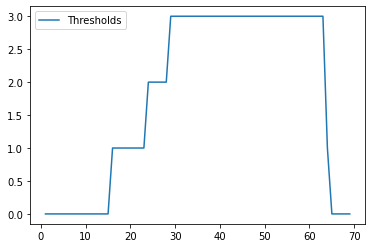

In [354]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1,70,1)
levels = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k, std=0.1)

    rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
    y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

    sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)

    level = 0
    for t in residual_error_thresholds:
        if sin_test_loss < t:
            level += 1
    levels.append(level)

plt.plot(num_of_kernels, levels, label="Thresholds")
plt.legend()
plt.show()

Loss: 6.2173
Residual Error (MAE): 0.0993


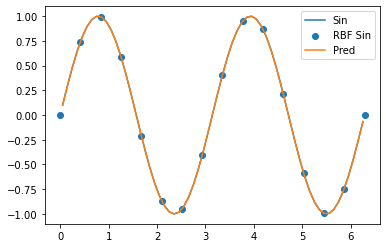

In [362]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=16, std=0.1)

rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)
y_pred_test = rbf_sin.predict(X_test)

plt.plot(X_test, y_test_sin, label="Sin")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF Sin")
plt.plot(X_test, y_test_sin, label="Pred")
plt.legend()
plt.show()
